<a href="https://colab.research.google.com/github/vilua0202/emotion_classification_v1/blob/master/Sentiment_Emotion_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Nhận diện cảm xúc trong câu nói**
Bao gồm 6 cảm xúc: sadness: buồn bã, joy: thích thú,neutral: trung tính, anger: tức giận, fear: nỗi sợ, surprise: bất ngờ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Khai báo thư viện

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Load dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Sentiment_Emotions_1/data/text.csv')

In 10 hàng đầu trong dataset

In [ ]:
df.head(10)

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
5,5,i was beginning to feel quite disheartened,0
6,6,i would think that whomever would be lucky eno...,2
7,7,i fear that they won t ever feel that deliciou...,1
8,8,im forever taking some time out to have a lie ...,5
9,9,i can still lose the weight without feeling de...,0


In [ ]:
df.drop(columns='Unnamed: 0', inplace=True)

Tổng quan về dataset

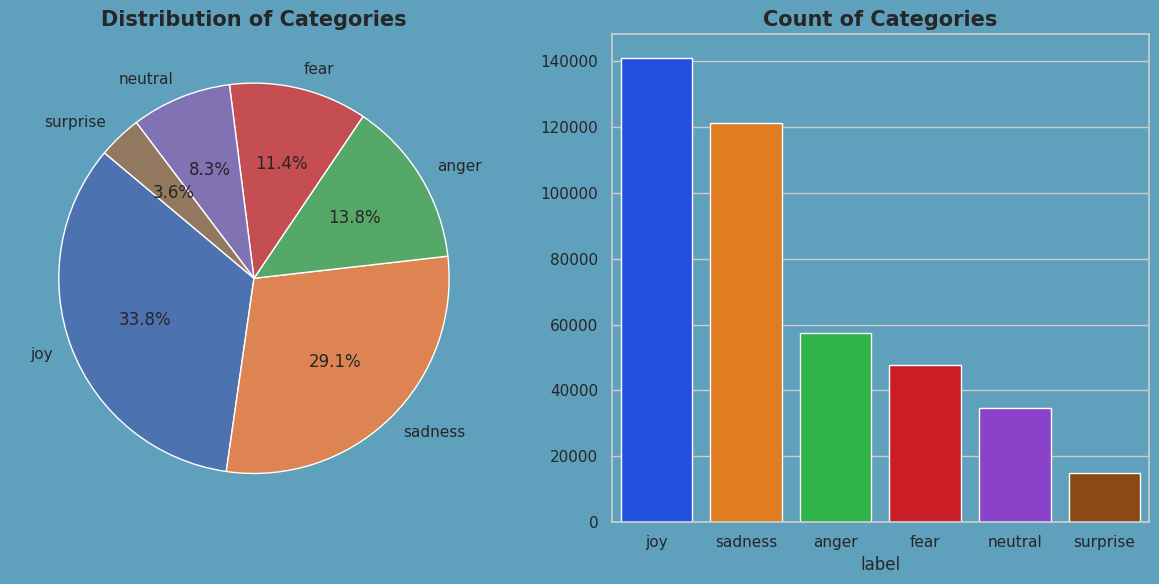

In [ ]:
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'neutral',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

df['label'] = df['label'].map(emotion_map)
count = df['label'].value_counts()

background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color, 'figure.facecolor': background_color})

fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor=background_color)

palette = sns.color_palette("bright", len(count))
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories', fontsize=15, fontweight='bold')

sns.barplot(x=count.index, y=count.values, ax=axs[1], palette=palette)
axs[1].set_title('Count of Categories', fontsize=15, fontweight='bold')

plt.tight_layout()

plt.show()

**DATA CLEANING**

1.CHAT WORDS (Định nghĩa lại các từ viết tắt)

In [ ]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

Chuẩn hóa từ

In [ ]:
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

df['text'] = df['text'].apply(replace_chat_words)

2. NON ALPHA NUMERIC CHARACTERS (Xóa các chữ mà k phải là chữ hoặc số)

In [ ]:
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

df.head()

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear


3. STOP WORDS (Xóa bỏ các từ quen thuộc)

In [ ]:
stop = stopwords.words('english')
df["text"] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df.head()

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear


4. Lowercasing (Chuyển đổi sang in thường)

In [ ]:
df['text'] = df['text'].str.lower()
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


5. REMOVING NUMERIC (Xóa bỏ các số)

In [ ]:
df['text'] = df['text'].str.replace(r'\d+', '', regex=True)
df.head()

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear


6 | REMOVING WHITE SPACE (Xóa bỏ các khoảng trắng)

In [ ]:
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


7 | REMOVING SPECIAL CHARACTER(Xoá kí tự đặc biệt)

In [ ]:
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


8 | REMOVING URLS(xoá bỏ đường dẫn url)

In [ ]:
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


**LSTM**

Tạo từ điển giữa label và giá trị của nó khi đc mã hoá

In [ ]:
label_mapping = {'sadness':0, 'joy':1, 'neutral':2, 'anger':3, 'fear':4,'surprise':5}

df['label'] = df['label'].map(label_mapping)

Chia tập train và test

In [ ]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Lấy giá trị của 60000 từ phổ biến nhất trong dataset để training



In [ ]:
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

Chuyển các từ trong câu thành vector có giá trị là chỉ số của các phần tử trong từ điển










In [ ]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In ra độ dài dài nhất của câu đã mã hoá

In [ ]:
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 79


Thêm padding các số 0 vào sau các câu

In [ ]:
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

In [ ]:
input_size = np.max(X_train_padded) + 1
input_size

60000

Thiết lập model BiLSTM

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=input_size, output_dim=100,input_shape=(79,)))

model.add(Bidirectional(LSTM(128)))

model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 79, 100)             │       6,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,252,358 (23.85 MB)

 Trainable params: 6,251,846 (23.85 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
# Model Train
history = model.fit(X_train_padded, y_train, epochs=15, batch_size=32, validation_data=(X_test_padded, y_test),callbacks=[EarlyStopping(patience=3)])

Epoch 1/15
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 3857s 370ms/step - accuracy: 0.8414 - loss: 0.4205 - val_accuracy: 0.9383 - val_loss: 0.0982
Epoch 2/15
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 3822s 366ms/step - accuracy: 0.9366 - loss: 0.1110 - val_accuracy: 0.9392 - val_loss: 0.0941
Epoch 3/15
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 3847s 364ms/step - accuracy: 0.9386 - loss: 0.1022 - val_accuracy: 0.9402 - val_loss: 0.0928
Epoch 4/15
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 3628s 348ms/step - accuracy: 0.9407 - loss: 0.0961 - val_accuracy: 0.9380 - val_loss: 0.1043
Epoch 5/15
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 3542s 340ms/step - accuracy: 0.9417 - loss: 0.0929 - val_accuracy: 0.9402 - val_loss: 0.0948
Epoch 6/15
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 3669s 350ms/step - accuracy: 0.9420 - loss: 0.0914 - val_accuracy: 0.9393 - val_loss: 0.0972


Mở rộng so sánh với model MultinomialNB

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer()

training_data = count_vector.fit_transform(X_train)

testing_data = count_vector.transform(X_test)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB()

In [ ]:
from sklearn.metrics import classification_report

# Dự đoán trên tập kiểm tra
y_pred = naive_bayes.predict(testing_data)

# In ra báo cáo phân loại
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     24201
           1       0.86      0.94      0.89     28164
           2       0.83      0.62      0.71      6929
           3       0.91      0.85      0.88     11441
           4       0.84      0.81      0.83      9594
           5       0.88      0.40      0.55      3033

    accuracy                           0.87     83362
   macro avg       0.87      0.76      0.80     83362
weighted avg       0.87      0.87      0.86     83362



Save model

In [ ]:
# Lưu mô hình sau khi huấn luyện
model.save('/content/drive/MyDrive/Sentiment_Emotions_1/checkpoint/ckpt4.h5')

In [ ]:
# Lưu tokenizer sau khi đã fit
import pickle
with open('/content/drive/MyDrive/Sentiment_Emotions_1/tokenizer4.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
from tensorflow.keras.models import load_model
import pickle
import numpy as np

# Tải lại mô hình đã lưu
model = load_model('/content/drive/MyDrive/Sentiment_Emotions_1/checkpoint/ckpt4.h5')

# Tải lại tokenizer đã lưu
with open('/content/drive/MyDrive/Sentiment_Emotions_1/tokenizer4.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


In [ ]:
# Nhập để test
#I felt so happy when I saw my best friend after years of being apart :Tôi cảm thấy thật hạnh phúc khi được gặp lại người bạn thân sau nhiều năm xa cách
#It makes me furious when people don't keep their promises :Tôi rất tức giận khi mọi người không giữ lời hứa
#I looked at the photos from our last vacation and couldn't help but feel a deep sadness :Tôi nhìn những bức ảnh về kỳ nghỉ vừa qua của chúng tôi và không khỏi cảm thấy một nỗi buồn sâu sắc
#Winning the championship was the happiest moment of my life

new_text = ["you are my sunshine"]
new_text_sequences = tokenizer.texts_to_sequences(new_text)
new_text_padded = pad_sequences(new_text_sequences, maxlen=maxlen, padding='post')
predictions = model.predict(new_text_padded)

# Danh sách nhãn cảm xúc
labels = ['sadness', 'joy', 'neutral', 'anger', 'fear', 'surprise']

# Lấy nhãn có xác suất cao nhất
predicted_label = labels[np.argmax(predictions)]
print(f"Dự đoán: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Dự đoán: joy
